# MTA Analysis

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import datetime
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
# Source: http://web.mta.info/developers/turnstile.html
dates=[210417, 210410 , 210403 ,210327 ,210320 , 210313 ,210306 , 210227 , 210220 , 210213 ,210206  ]
turnstiles_df=pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_210424.txt')
for i in dates:
    temp= pd.read_csv(f"http://web.mta.info/developers/data/nyct/turnstile/turnstile_{i}.txt")  
    turnstiles_df= pd.concat([turnstiles_df, temp])

turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,00:00:00,REGULAR,7557815,2581231
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,04:00:00,REGULAR,7557822,2581234
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,08:00:00,REGULAR,7557829,2581248
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,12:00:00,REGULAR,7557891,2581318
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,16:00:00,REGULAR,7558017,2581365


In [3]:
engine = create_engine("sqlite:///MTA_data.db") 
turnstiles_df.to_sql('MTA_data',engine,if_exists='replace',index=False)

In [8]:
all_tables = engine.table_names()
print(all_tables)

['MTA_data']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  """Entry point for launching an IPython kernel.


In [9]:
turnstiles_df = pd.read_sql('SELECT * FROM  MTA_data ;', engine)
turnstiles_df

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,00:00:00,REGULAR,7557815,2581231
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,04:00:00,REGULAR,7557822,2581234
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,08:00:00,REGULAR,7557829,2581248
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,12:00:00,REGULAR,7557891,2581318
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,16:00:00,REGULAR,7558017,2581365
...,...,...,...,...,...,...,...,...,...,...,...
2509012,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,02/05/2021,04:00:00,REGULAR,5554,544
2509013,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,02/05/2021,08:00:00,REGULAR,5554,544
2509014,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,02/05/2021,12:00:00,REGULAR,5554,544
2509015,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,02/05/2021,16:00:00,REGULAR,5554,544


In [4]:
turnstiles_df.shape

(2509017, 11)

In [5]:
turnstiles_df.columns 

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [6]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns] # #I need to strip the stirngs in column in order to remove whitespaces
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [7]:

turnstiles_df.DATE.value_counts().sort_index() # Sort

01/30/2021    29845
01/31/2021    29786
02/01/2021    29971
02/02/2021    29802
02/03/2021    29975
              ...  
04/19/2021    29910
04/20/2021    29816
04/21/2021    29821
04/22/2021    29926
04/23/2021    29945
Name: DATE, Length: 84, dtype: int64

In [8]:
# #I will combine and convert the DATE and TIME columns
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, 
                                            format="%m/%d/%Y %H:%M:%S")

In [9]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,00:00:00,REGULAR,7557815,2581231,2021-04-17 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,04:00:00,REGULAR,7557822,2581234,2021-04-17 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,08:00:00,REGULAR,7557829,2581248,2021-04-17 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,12:00:00,REGULAR,7557891,2581318,2021-04-17 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/17/2021,16:00:00,REGULAR,7558017,2581365,2021-04-17 16:00:00


In [10]:
# I will check if we have duplicate rows and drop them
(turnstiles_df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"]).ENTRIES.count().reset_index().sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
1687584,R145,R032,00-00-02,TIMES SQ-42 ST,2021-02-02 07:00:00,2
1687602,R145,R032,00-00-02,TIMES SQ-42 ST,2021-02-05 07:00:00,2
679273,N071,R013,00-00-01,34 ST-PENN STA,2021-04-08 08:00:00,2
681309,N071,R013,00-06-00,34 ST-PENN STA,2021-04-08 08:00:00,2
680283,N071,R013,00-00-03,34 ST-PENN STA,2021-04-08 08:00:00,2


In [11]:
# drop duplicate value then sort 
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
                          inplace=True, ascending=False)
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [12]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A002,R051,02-00-00,59 ST,2021-01-30 03:00:00,1
1672637,R138,R293,00-05-01,34 ST-PENN STA,2021-03-01 21:00:00,1
1672630,R138,R293,00-05-01,34 ST-PENN STA,2021-02-28 17:00:00,1
1672631,R138,R293,00-05-01,34 ST-PENN STA,2021-02-28 21:00:00,1
1672632,R138,R293,00-05-01,34 ST-PENN STA,2021-03-01 01:00:00,1


In [13]:
# #I will drop the description column since we don't need it anymore
turnstiles_df = turnstiles_df.drop([ "DESC"], axis=1, errors="ignore")
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
209104,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,21:00:00,5554,547,2021-04-23 21:00:00
209103,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,17:00:00,5554,547,2021-04-23 17:00:00
209102,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,13:00:00,5554,547,2021-04-23 13:00:00
209101,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,09:00:00,5554,547,2021-04-23 09:00:00
209100,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,05:00:00,5554,547,2021-04-23 05:00:00


In [14]:
turnstiles_df.shape

(2508951, 11)

In [15]:
#I will look for missing values
turnstiles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2508951 entries, 209104 to 0
Data columns (total 11 columns):
 #   Column     Dtype         
---  ------     -----         
 0   C/A        object        
 1   UNIT       object        
 2   SCP        object        
 3   STATION    object        
 4   LINENAME   object        
 5   DIVISION   object        
 6   DATE       object        
 7   TIME       object        
 8   ENTRIES    int64         
 9   EXITS      int64         
 10  DATE_TIME  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 229.7+ MB


In [21]:
turnstiles_df.isna().sum() #I will look for missing valuesno , null values found

C/A          0
UNIT         0
SCP          0
STATION      0
LINENAME     0
DIVISION     0
DATE         0
TIME         0
ENTRIES      0
EXITS        0
DATE_TIME    0
dtype: int64

In [22]:
turnstiles_df.isna()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME
209104,False,False,False,False,False,False,False,False,False,False,False
209103,False,False,False,False,False,False,False,False,False,False,False
209102,False,False,False,False,False,False,False,False,False,False,False
209101,False,False,False,False,False,False,False,False,False,False,False
209100,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2299942,False,False,False,False,False,False,False,False,False,False,False
2299941,False,False,False,False,False,False,False,False,False,False,False
2299940,False,False,False,False,False,False,False,False,False,False,False
2299939,False,False,False,False,False,False,False,False,False,False,False


In [16]:
turnstiles_df["Traffic"] = turnstiles_df["ENTRIES"] +turnstiles_df["EXITS"] 
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,Traffic
209104,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,21:00:00,5554,547,2021-04-23 21:00:00,6101
209103,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,17:00:00,5554,547,2021-04-23 17:00:00,6101
209102,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,13:00:00,5554,547,2021-04-23 13:00:00,6101
209101,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,09:00:00,5554,547,2021-04-23 09:00:00,6101
209100,TRAM2,R469,00-05-01,RIT-ROOSEVELT,R,RIT,04/23/2021,05:00:00,5554,547,2021-04-23 05:00:00,6101


In [17]:
turnstiles_daily = (turnstiles_df
                        .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .Traffic.first()) # 

In [18]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,Traffic
0,A002,R051,02-00-00,59 ST,01/30/2021,10089644
1,A002,R051,02-00-00,59 ST,01/31/2021,10090003
2,A002,R051,02-00-00,59 ST,02/01/2021,10090292
3,A002,R051,02-00-00,59 ST,02/02/2021,10090808
4,A002,R051,02-00-00,59 ST,02/03/2021,10091648


In [20]:
turnstiles_daily[["PREV_DATE", "PREV_Traffic"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "Traffic"]
                                                       .apply(lambda grp: grp.shift(1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [21]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,Traffic,PREV_DATE,PREV_Traffic
0,A002,R051,02-00-00,59 ST,01/30/2021,10089644,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/31/2021,10090003,01/30/2021,10089644.0
2,A002,R051,02-00-00,59 ST,02/01/2021,10090292,01/31/2021,10090003.0
3,A002,R051,02-00-00,59 ST,02/02/2021,10090808,02/01/2021,10090292.0
4,A002,R051,02-00-00,59 ST,02/03/2021,10091648,02/02/2021,10090808.0


In [22]:
turnstiles_daily.tail()

,C/A,UNIT,SCP,STATION,DATE,Traffic,PREV_DATE,PREV_Traffic
419444,TRAM2,R469,00-05-01,RIT-ROOSEVELT,04/19/2021,6101,04/18/2021,6101.0
419445,TRAM2,R469,00-05-01,RIT-ROOSEVELT,04/20/2021,6101,04/19/2021,6101.0
419446,TRAM2,R469,00-05-01,RIT-ROOSEVELT,04/21/2021,6101,04/20/2021,6101.0
419447,TRAM2,R469,00-05-01,RIT-ROOSEVELT,04/22/2021,6101,04/21/2021,6101.0
419448,TRAM2,R469,00-05-01,RIT-ROOSEVELT,04/23/2021,6101,04/22/2021,6101.0


In [23]:
turnstiles_daily[turnstiles_daily["Traffic"] < turnstiles_daily["PREV_Traffic"]].head()

,C/A,UNIT,SCP,STATION,DATE,Traffic,PREV_DATE,PREV_Traffic
387,A002,R051,02-03-02,59 ST,03/22/2021,326,03/21/2021,1.551085e+07
3275,A011,R080,01-03-00,57 ST-7 AV,01/31/2021,1375303228,01/30/2021,1.375304e+09
3276,A011,R080,01-03-00,57 ST-7 AV,02/01/2021,1375302778,01/31/2021,1.375303e+09
3277,A011,R080,01-03-00,57 ST-7 AV,02/02/2021,1375302119,02/01/2021,1.375303e+09
3278,A011,R080,01-03-00,57 ST-7 AV,02/03/2021,1375301090,02/02/2021,1.375302e+09


In [24]:
(turnstiles_daily[turnstiles_daily["Traffic"] < turnstiles_daily["PREV_Traffic"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A   UNIT  SCP       STATION        
A002  R051  02-03-02  59 ST               1
A011  R080  01-03-00  57 ST-7 AV         83
A025  R023  01-06-00  34 ST-HERALD SQ     1
A033  R170  02-00-05  14 ST-UNION SQ      1
A047  R087  00-06-01  CITY HALL           1
                                         ..
R619  R059  00-03-00  GRAND ARMY PLAZ     1
R622  R123  00-00-00  FRANKLIN AV        83
R624  R124  00-00-02  KINGSTON AV         1
R730  R431  00-00-04  EASTCHSTER/DYRE    83
S101  R070  00-00-04  ST. GEORGE          1
Length: 206, dtype: int64

In [25]:
def get_daily_counts(row, max_counter):
    counter = row["Traffic"] - row["PREV_Traffic"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["Traffic"], row["PREV_Traffic"])
        counter = min(row["Traffic"], row["PREV_Traffic"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
# It'd probably be a good idea to use a number even significantly smaller than 1 million as the limit!
turnstiles_daily["DAILY_Traffic"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

326 15510851.0
301 41538834.0
1033 25902636.0
393220 202882759.0
2685 1648400.0
197 2024782.0
262152 1023412047.0
8273099 5447183.0
1638448 8273831.0
136 1641837.0
766 1288384.0
327907 3435059.0
180 17473522.0
252 1938733.0
262388 3737209.0
393225 9092129.0
108 2669927.0
2818578731 11067412.0
16712067 8670197.0
279 16712991.0
417 1089794.0
262144 33554713.0
63 1303601.0
241 202655055.0
300 5825694.0
198 17997783.0
3379 29079019.0
112 14331544.0
258 1052823.0
1377460 2549981.0
1261 1379132.0
2 83886189.0
262402 2052821.0
2098790415 0.0
79867705 3255074065.0
193 21661025.0
1670 7282017.0
2680 38545082.0
262155 83889823.0
2021 1167896.0
0 5741191.0
262145 671505146.0
262191 67652738.0
687341594 42.0
1341 1147371.0
2293950 5523203.0
192 24344065.0
116 2397044.0
262613 18971960.0
446 15637516.0
1214 5929767.0
320 11785403.0
113 3466670.0
262145 83886994.0
55 1583496.0
66 3223870.0
546 1824263347.0
854434 14803642.0
66651 19697870.0
137 32848922.0
758 1066014.0
3053485533 11979295.0
31917827

In [26]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,Traffic,PREV_DATE,PREV_Traffic,DAILY_Traffic
0,A002,R051,02-00-00,59 ST,01/30/2021,10089644,NaN,NaN,NaN
1,A002,R051,02-00-00,59 ST,01/31/2021,10090003,01/30/2021,10089644.0,359.0
2,A002,R051,02-00-00,59 ST,02/01/2021,10090292,01/31/2021,10090003.0,289.0
3,A002,R051,02-00-00,59 ST,02/02/2021,10090808,02/01/2021,10090292.0,516.0
4,A002,R051,02-00-00,59 ST,02/03/2021,10091648,02/02/2021,10090808.0,840.0


In [27]:
station_daily = turnstiles_daily.groupby(["STATION", "DATE"])[['DAILY_Traffic']].sum().reset_index()
station_daily.head()

,STATION,DATE,DAILY_Traffic
0,1 AV,01/30/2021,0.0
1,1 AV,01/31/2021,8615.0
2,1 AV,02/01/2021,7157.0
3,1 AV,02/02/2021,10287.0
4,1 AV,02/03/2021,14911.0


In [28]:
station_totals = station_daily.groupby('STATION').sum()\
    .sort_values('DAILY_Traffic', ascending=False)\
    .reset_index()

station_totals.head()

,STATION,DAILY_Traffic
0,34 ST-PENN STA,6190055.0
1,TIMES SQ-42 ST,5317244.0
2,34 ST-HERALD SQ,5295636.0
3,86 ST,5213711.0
4,GRD CNTRL-42 ST,4616105.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

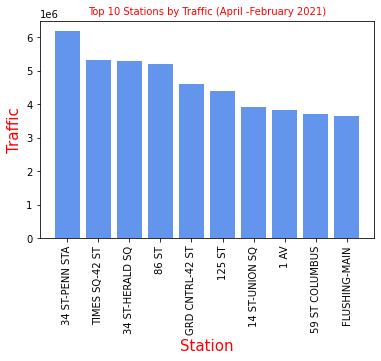

In [30]:
plt.bar(x=station_totals['STATION'][:10], height=station_totals['DAILY_Traffic'][:10] , color='#6495ED')
plt.title('Top 10 Stations by Traffic (April -February 2021)',Family='CALIBRI',fontsize = 10,loc='CENTER',color='red') 
plt.xlabel('Station', fontsize= 15,family='sans-serif', color='red')
plt.ylabel('Traffic', fontsize= 15,family='sans-serif' , color='red');
plt.xticks(rotation=90)



In [31]:
Top5station=station_totals.head(5);

findfont: Font family ['CALIBRI'] not found. Falling back to DejaVu Sans.


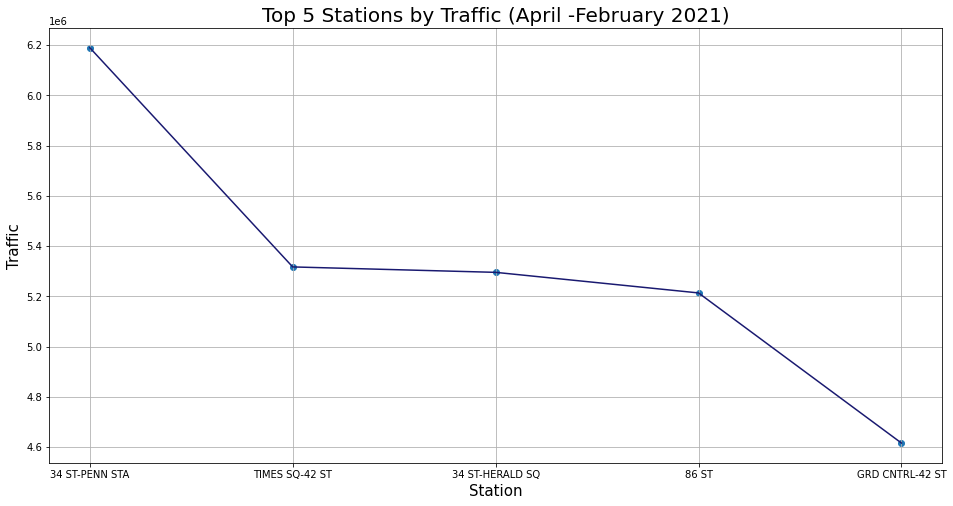

In [32]:
plt.figure(figsize=(16,8))
plt.title('Top 5 Stations by Traffic (April -February 2021)',family='CALIBRI',fontsize = 20,loc='CENTER',color='black');

sns.lineplot(data = Top5station, x = Top5station.STATION, y = Top5station.DAILY_Traffic , color='#191970') 
plt.xlabel('Station', fontsize= 15,family='sans-serif', color='black') 
plt.ylabel('Traffic', fontsize= 15,family='sans-serif' , color='black');
plt.scatter(Top5station.STATION,Top5station.DAILY_Traffic);
plt.grid()
plt.show()

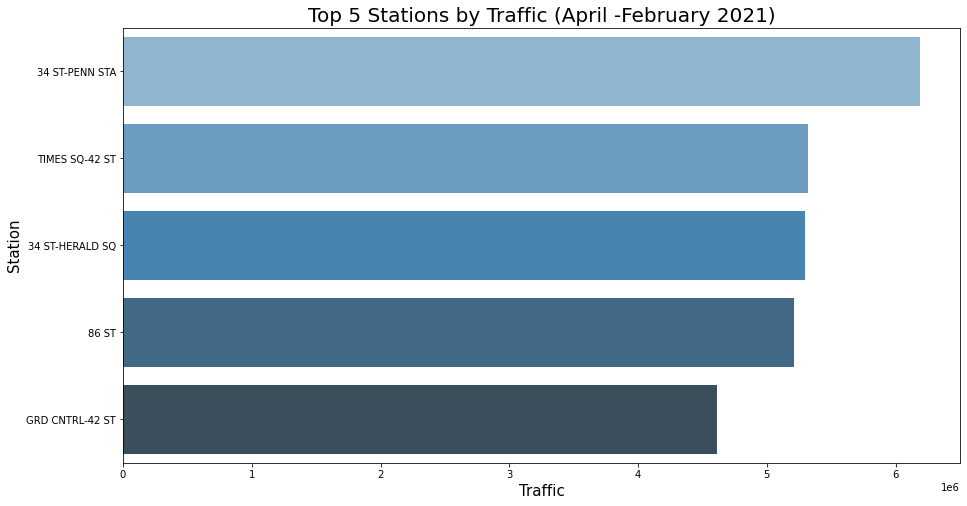

In [33]:
plt.figure(figsize=(15,8))
plt.title('Top 5 Stations by Traffic (April -February 2021)',family='CALIBRI',fontsize = 20,loc='CENTER',color='black');
sns.barplot(data = Top5station, y =Top5station.STATION, x =Top5station.DAILY_Traffic , palette="Blues_d")
plt.xlabel('Traffic', fontsize= 15,family='sans-serif', color='black')
plt.ylabel('Station', fontsize= 15,family='sans-serif' , color='black');

plt.show()